In [1]:
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements.txt'


### 1. Import Dependencies

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.2f}'.format)

### 2. Load EDA Results

In [3]:
# Load data from EDA notebook
df = pd.read_csv(r'D:\MY\Personal Projects\Zuu-Crew Projects\Building Production Ready ML Systems\Advance Telco Customer Churn Prediction\data\processed\telco_eda_complete.csv')
print(f"Dataset loaded: {df.shape}")
print(f"Missing values: {df.isnull().sum().sum()}")
df.head()

Dataset loaded: (7043, 22)
Missing values: 22


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,tenure_group
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,0-12
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No,25-36
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,0-12
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No,37-48
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,0-12


In [4]:
# Recreate feature categories from EDA insights
demographic_features = ['gender', 'SeniorCitizen', 'Partner', 'Dependents']
account_features = ['tenure', 'Contract', 'PaperlessBilling', 'PaymentMethod']
service_features = ['PhoneService', 'MultipleLines', 'InternetService', 
                   'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 
                   'TechSupport', 'StreamingTV', 'StreamingMovies']
financial_features = ['MonthlyCharges', 'TotalCharges']

print(f"Feature categories identified:")
print(f"Demographic: {len(demographic_features)} features")
print(f"Account: {len(account_features)} features")
print(f"Service: {len(service_features)} features")
print(f"Financial: {len(financial_features)} features")

Feature categories identified:
Demographic: 4 features
Account: 4 features
Service: 9 features
Financial: 2 features


### 3. Handle Missing Values

In [5]:
# Check missing values
missing_values = df.isnull().sum()
missing_df = pd.DataFrame({
    'Feature': missing_values.index,
    'Missing_Count': missing_values.values,
    'Missing_Percentage': (missing_values.values / len(df)) * 100
})
missing_df = missing_df[missing_df['Missing_Count'] > 0].sort_values('Missing_Count', ascending=False)

if len(missing_df) > 0:
    print("Missing Values Found:")
    print(missing_df)
else:
    print("No missing values found!")

Missing Values Found:
         Feature  Missing_Count  Missing_Percentage
19  TotalCharges             11                0.16
21  tenure_group             11                0.16


In [6]:
# Handle TotalCharges missing values
if 'TotalCharges' in missing_df['Feature'].values:
    print("Handling TotalCharges missing values...")
    
    # Analyze missing TotalCharges
    missing_mask = df['TotalCharges'].isnull()
    print(f"Customers with missing TotalCharges: {missing_mask.sum()}")
    
    # Check tenure for missing TotalCharges
    print("Tenure distribution for missing TotalCharges:")
    print(df[missing_mask]['tenure'].describe())
    
    # Strategy: For customers with 0 tenure, set TotalCharges to 0
    # For others, impute with MonthlyCharges * tenure
    df_engineered = df.copy()
    
    # Method 1: Set to 0 for zero tenure customers
    zero_tenure_mask = (df_engineered['tenure'] == 0) & df_engineered['TotalCharges'].isnull()
    df_engineered.loc[zero_tenure_mask, 'TotalCharges'] = 0
    
    # Method 2: Impute with MonthlyCharges * tenure for others
    remaining_missing = df_engineered['TotalCharges'].isnull()
    df_engineered.loc[remaining_missing, 'TotalCharges'] = (
        df_engineered.loc[remaining_missing, 'MonthlyCharges'] * 
        df_engineered.loc[remaining_missing, 'tenure']
    )
    
    print(f"Missing values after imputation: {df_engineered['TotalCharges'].isnull().sum()}")
else:
    df_engineered = df.copy()
    print("No missing values in TotalCharges to handle.")

Handling TotalCharges missing values...
Customers with missing TotalCharges: 11
Tenure distribution for missing TotalCharges:
count   11.00
mean     0.00
std      0.00
min      0.00
25%      0.00
50%      0.00
75%      0.00
max      0.00
Name: tenure, dtype: float64
Missing values after imputation: 0


### 4. Create Telco-Specific Derived Features

#### 4.1 Tenure Categories

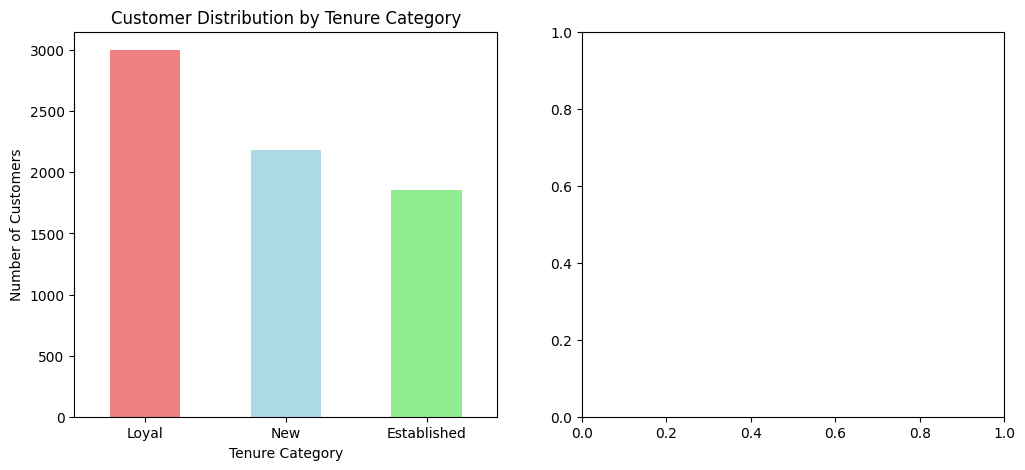

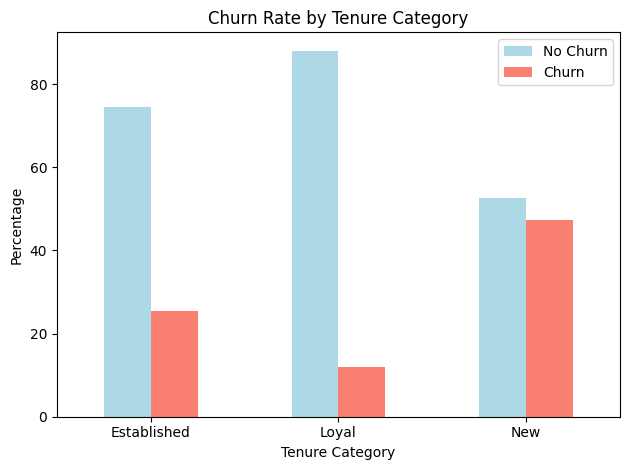

Churn rates by tenure category:
Established :  25.5% (1,856 customers)
Loyal       :  11.9% (3,001 customers)
New         :  47.4% (2,186 customers)


In [7]:
# Create tenure categories based on customer lifecycle
def categorize_tenure(tenure):
    if tenure <= 12:
        return 'New'  # 0-12 months
    elif tenure <= 36:
        return 'Established'  # 13-36 months
    else:
        return 'Loyal'  # 37+ months

df_engineered['tenure_category'] = df_engineered['tenure'].apply(categorize_tenure)

# Visualize tenure categories
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
tenure_counts = df_engineered['tenure_category'].value_counts()
tenure_counts.plot(kind='bar', color=['lightcoral', 'lightblue', 'lightgreen'])
plt.title('Customer Distribution by Tenure Category')
plt.xlabel('Tenure Category')
plt.ylabel('Number of Customers')
plt.xticks(rotation=0)

plt.subplot(1, 2, 2)
tenure_churn = pd.crosstab(df_engineered['tenure_category'], df_engineered['Churn'], normalize='index') * 100
tenure_churn.plot(kind='bar', color=['lightblue', 'salmon'])
plt.title('Churn Rate by Tenure Category')
plt.xlabel('Tenure Category')
plt.ylabel('Percentage')
plt.legend(['No Churn', 'Churn'])
plt.xticks(rotation=0)

plt.tight_layout()
plt.show()

print("Churn rates by tenure category:")
for category in tenure_churn.index:
    churn_rate = tenure_churn.loc[category, 'Yes']
    count = tenure_counts[category]
    print(f"{category:12s}: {churn_rate:5.1f}% ({count:,} customers)")

#### 4.2 Service Adoption Score

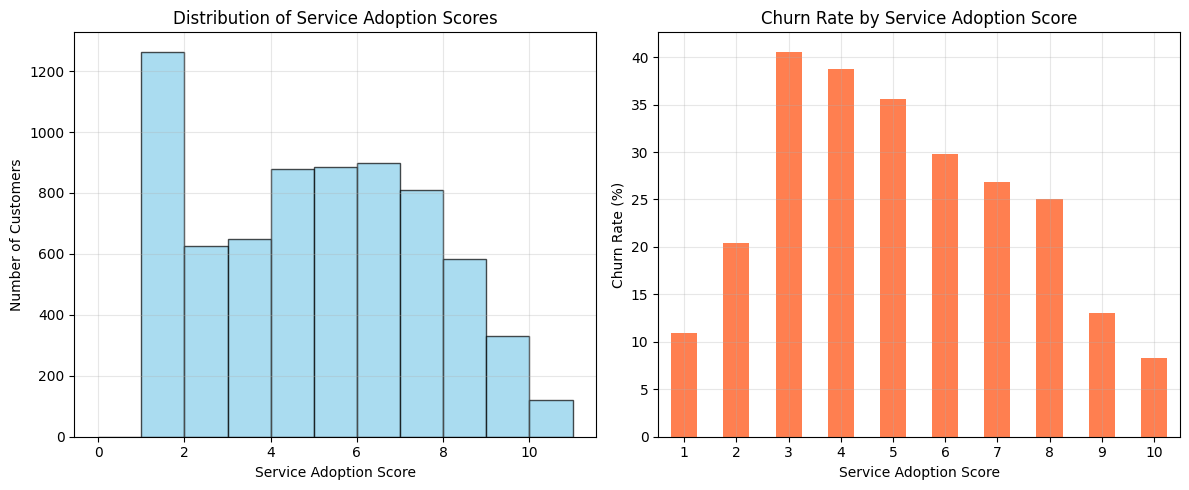

Service Adoption Score range: 1 - 10
Average score: 4.59
Score correlation with churn: 0.042


In [8]:
# Create service adoption score based on number of services used
def calculate_service_adoption_score(row):
    score = 0
    
    # Basic services (1 point each)
    if row['PhoneService'] == 'Yes':
        score += 1
    if row['MultipleLines'] == 'Yes':
        score += 1
    
    # Internet services (1 point each, but 2 for fiber)
    if row['InternetService'] == 'DSL':
        score += 1
    elif row['InternetService'] == 'Fiber optic':
        score += 2
    
    # Add-on services (1 point each)
    addon_services = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 
                     'TechSupport', 'StreamingTV', 'StreamingMovies']
    for service in addon_services:
        if row[service] == 'Yes':
            score += 1
    
    return score

df_engineered['service_adoption_score'] = df_engineered.apply(calculate_service_adoption_score, axis=1)

# Analyze service adoption score
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
df_engineered['service_adoption_score'].hist(bins=range(0, df_engineered['service_adoption_score'].max()+2), 
                                            alpha=0.7, color='skyblue', edgecolor='black')
plt.title('Distribution of Service Adoption Scores')
plt.xlabel('Service Adoption Score')
plt.ylabel('Number of Customers')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
score_churn = df_engineered.groupby('service_adoption_score')['Churn'].apply(lambda x: (x == 'Yes').mean() * 100)
score_churn.plot(kind='bar', color='coral')
plt.title('Churn Rate by Service Adoption Score')
plt.xlabel('Service Adoption Score')
plt.ylabel('Churn Rate (%)')
plt.xticks(rotation=0)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Service Adoption Score range: {df_engineered['service_adoption_score'].min()} - {df_engineered['service_adoption_score'].max()}")
print(f"Average score: {df_engineered['service_adoption_score'].mean():.2f}")
print(f"Score correlation with churn: {df_engineered['service_adoption_score'].corr(df_engineered['Churn'].map({'No': 0, 'Yes': 1})):.3f}")

#### 4.3 Average Monthly Charges per Service

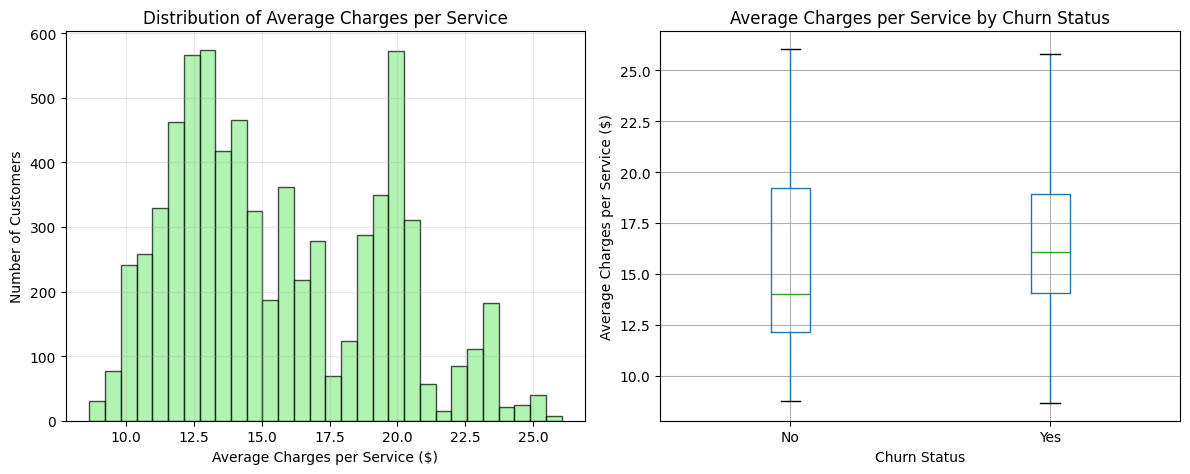

Average charges per service:
No Churn: $15.18
Yes Churn: $16.73
Difference: $1.55 higher for churned customers


In [9]:
# Calculate average monthly charges per service
df_engineered['avg_charges_per_service'] = (
    df_engineered['MonthlyCharges'] / 
    df_engineered['service_adoption_score'].replace(0, 1)  # Avoid division by zero
)

# Analyze price efficiency
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
df_engineered['avg_charges_per_service'].hist(bins=30, alpha=0.7, color='lightgreen', edgecolor='black')
plt.title('Distribution of Average Charges per Service')
plt.xlabel('Average Charges per Service ($)')
plt.ylabel('Number of Customers')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
# Box plot by churn status
df_engineered.boxplot(column='avg_charges_per_service', by='Churn', ax=plt.gca())
plt.title('Average Charges per Service by Churn Status')
plt.xlabel('Churn Status')
plt.ylabel('Average Charges per Service ($)')
plt.suptitle('')  # Remove default title

plt.tight_layout()
plt.show()

# Statistical comparison
no_churn_avg = df_engineered[df_engineered['Churn'] == 'No']['avg_charges_per_service'].mean()
yes_churn_avg = df_engineered[df_engineered['Churn'] == 'Yes']['avg_charges_per_service'].mean()

print(f"Average charges per service:")
print(f"No Churn: ${no_churn_avg:.2f}")
print(f"Yes Churn: ${yes_churn_avg:.2f}")
print(f"Difference: ${yes_churn_avg - no_churn_avg:.2f} higher for churned customers")

#### 4.4 Payment Reliability Indicators

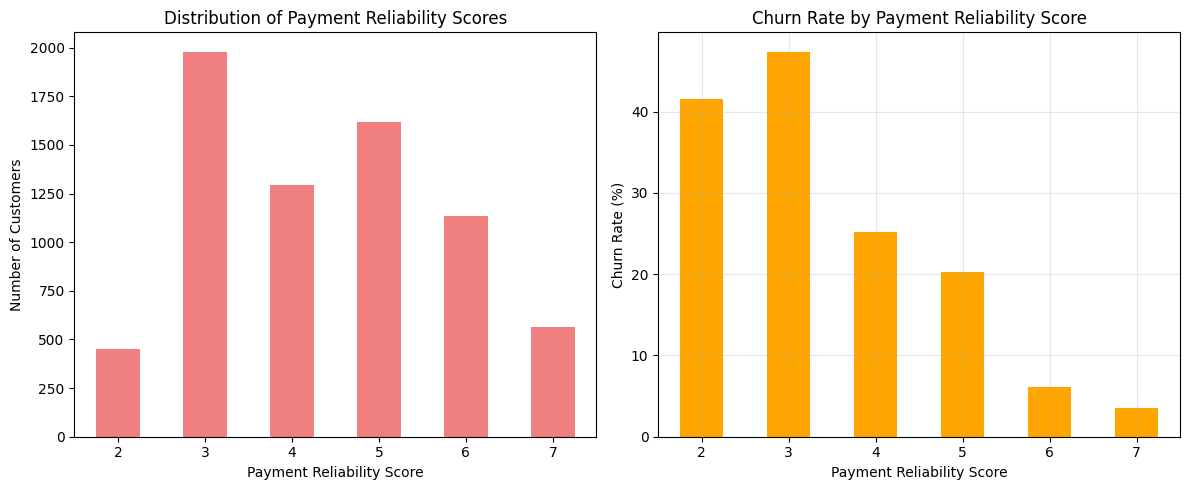

Churn rates by payment reliability score:
Score 2:  41.5% (453 customers)
Score 3:  47.4% (1,980 customers)
Score 4:  25.2% (1,294 customers)
Score 5:  20.3% (1,618 customers)
Score 6:   6.1% (1,134 customers)
Score 7:   3.5% (564 customers)


In [10]:
# Create payment reliability score
def calculate_payment_reliability(row):
    score = 0
    
    # Contract type (higher score for longer commitments)
    if row['Contract'] == 'Month-to-month':
        score += 1
    elif row['Contract'] == 'One year':
        score += 2
    elif row['Contract'] == 'Two year':
        score += 3
    
    # Payment method (higher score for automatic payments)
    if row['PaymentMethod'] in ['Electronic check']:
        score += 1
    elif row['PaymentMethod'] in ['Mailed check']:
        score += 2
    elif row['PaymentMethod'] in ['Bank transfer (automatic)', 'Credit card (automatic)']:
        score += 3
    
    # Paperless billing (digital engagement)
    if row['PaperlessBilling'] == 'Yes':
        score += 1
    
    return score

df_engineered['payment_reliability_score'] = df_engineered.apply(calculate_payment_reliability, axis=1)

# Analyze payment reliability
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
reliability_counts = df_engineered['payment_reliability_score'].value_counts().sort_index()
reliability_counts.plot(kind='bar', color='lightcoral')
plt.title('Distribution of Payment Reliability Scores')
plt.xlabel('Payment Reliability Score')
plt.ylabel('Number of Customers')
plt.xticks(rotation=0)

plt.subplot(1, 2, 2)
reliability_churn = df_engineered.groupby('payment_reliability_score')['Churn'].apply(lambda x: (x == 'Yes').mean() * 100)
reliability_churn.plot(kind='bar', color='orange')
plt.title('Churn Rate by Payment Reliability Score')
plt.xlabel('Payment Reliability Score')
plt.ylabel('Churn Rate (%)')
plt.xticks(rotation=0)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Churn rates by payment reliability score:")
for score in sorted(df_engineered['payment_reliability_score'].unique()):
    churn_rate = reliability_churn[score]
    count = reliability_counts[score]
    print(f"Score {score}: {churn_rate:5.1f}% ({count:,} customers)")

#### 4.5 Customer Value Segments

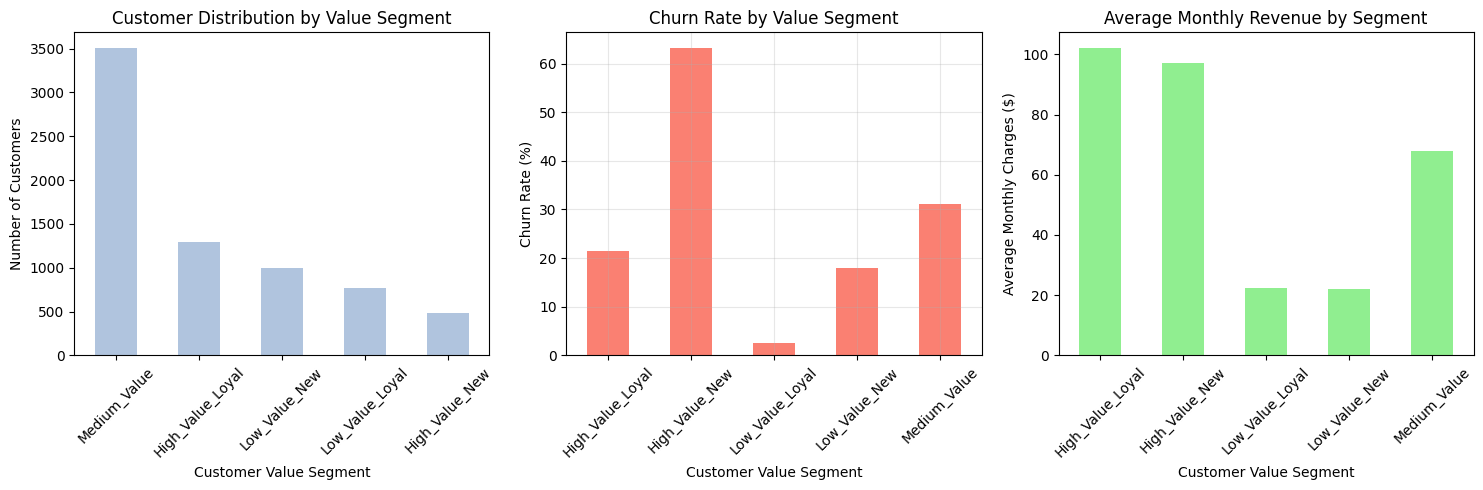

Customer Value Segment Analysis:
Medium_Value      : 3,510 customers,  31.1% churn, $67.92 avg monthly
High_Value_Loyal  : 1,292 customers,  21.4% churn, $102.22 avg monthly
Low_Value_New     : 998 customers,  17.9% churn, $22.11 avg monthly
Low_Value_Loyal   : 764 customers,   2.5% churn, $22.39 avg monthly
High_Value_New    : 479 customers,  63.3% churn, $97.03 avg monthly


In [11]:
# Create customer value segments based on monthly charges and tenure
def categorize_customer_value(row):
    monthly_charges = row['MonthlyCharges']
    tenure = row['tenure']
    
    # Define thresholds based on quartiles
    monthly_q75 = df_engineered['MonthlyCharges'].quantile(0.75)
    monthly_q25 = df_engineered['MonthlyCharges'].quantile(0.25)
    tenure_median = df_engineered['tenure'].median()
    
    if monthly_charges >= monthly_q75 and tenure >= tenure_median:
        return 'High_Value_Loyal'
    elif monthly_charges >= monthly_q75 and tenure < tenure_median:
        return 'High_Value_New'
    elif monthly_charges <= monthly_q25 and tenure >= tenure_median:
        return 'Low_Value_Loyal'
    elif monthly_charges <= monthly_q25 and tenure < tenure_median:
        return 'Low_Value_New'
    else:
        return 'Medium_Value'

df_engineered['customer_value_segment'] = df_engineered.apply(categorize_customer_value, axis=1)

# Analyze customer value segments
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
value_counts = df_engineered['customer_value_segment'].value_counts()
value_counts.plot(kind='bar', color='lightsteelblue')
plt.title('Customer Distribution by Value Segment')
plt.xlabel('Customer Value Segment')
plt.ylabel('Number of Customers')
plt.xticks(rotation=45)

plt.subplot(1, 3, 2)
value_churn = pd.crosstab(df_engineered['customer_value_segment'], df_engineered['Churn'], normalize='index') * 100
value_churn['Yes'].plot(kind='bar', color='salmon')
plt.title('Churn Rate by Value Segment')
plt.xlabel('Customer Value Segment')
plt.ylabel('Churn Rate (%)')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 3)
# Average revenue by segment
avg_revenue = df_engineered.groupby('customer_value_segment')['MonthlyCharges'].mean()
avg_revenue.plot(kind='bar', color='lightgreen')
plt.title('Average Monthly Revenue by Segment')
plt.xlabel('Customer Value Segment')
plt.ylabel('Average Monthly Charges ($)')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

print("Customer Value Segment Analysis:")
for segment in value_counts.index:
    count = value_counts[segment]
    churn_rate = value_churn.loc[segment, 'Yes']
    avg_rev = avg_revenue[segment]
    print(f"{segment:18s}: {count:,} customers, {churn_rate:5.1f}% churn, ${avg_rev:.2f} avg monthly")

### 5. Feature Interaction Analysis

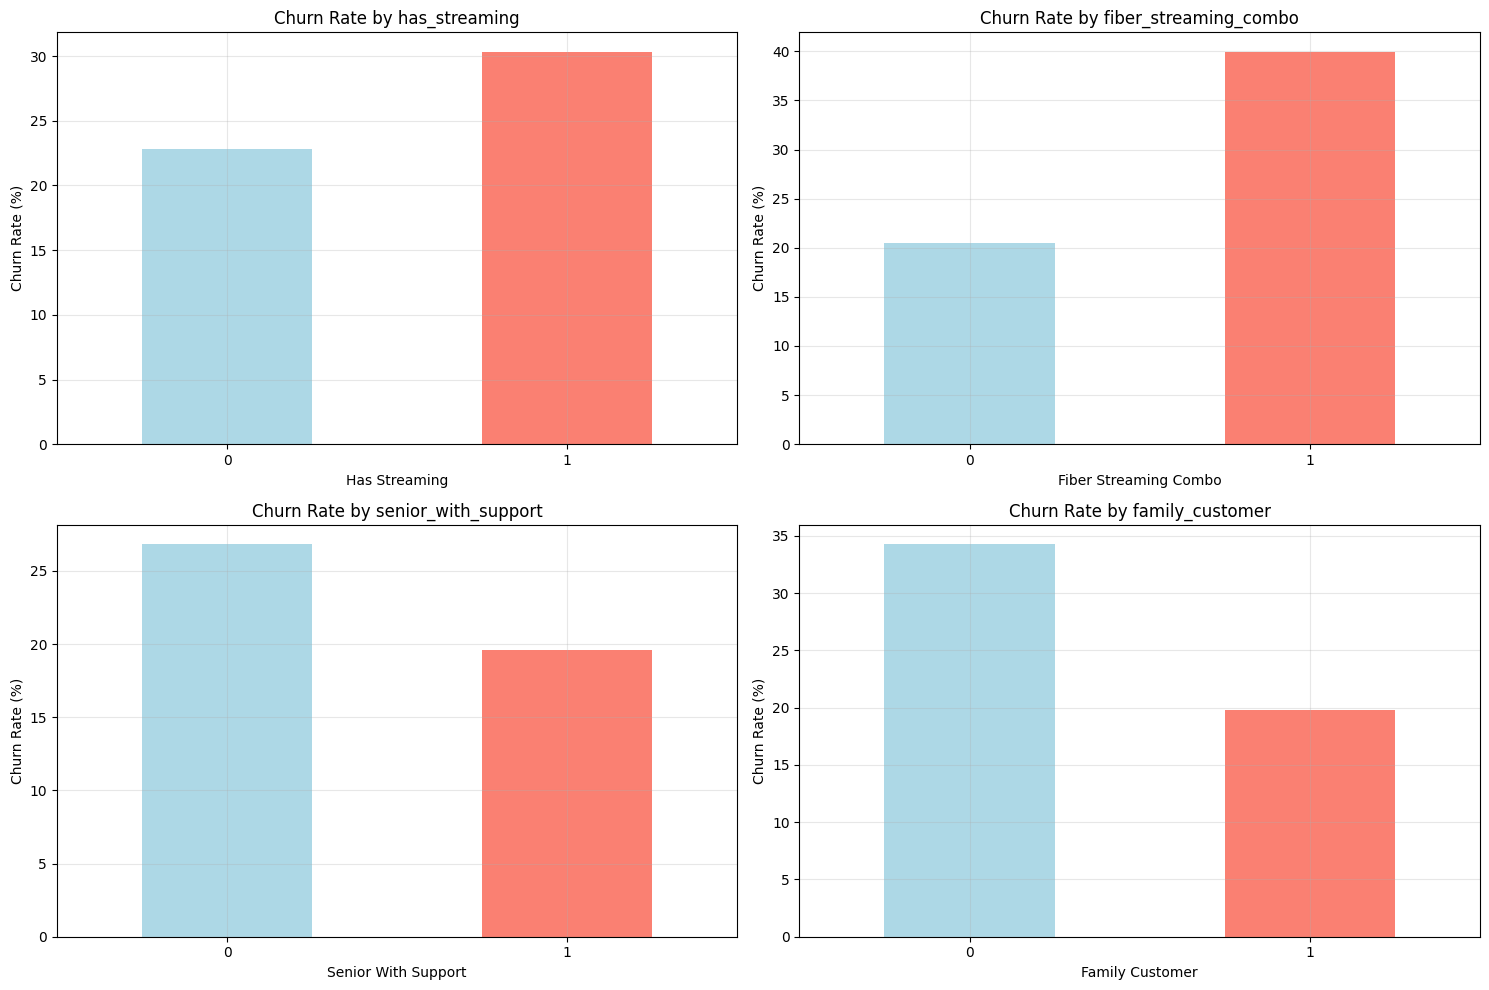

Interaction Feature Analysis:

Has Streaming:
  0:  22.8% churn (3,544 customers)
  1:  30.3% churn (3,499 customers)

Fiber Streaming Combo:
  0:  20.5% churn (4,852 customers)
  1:  39.9% churn (2,191 customers)

Senior With Support:
  0:  26.8% churn (6,783 customers)
  1:  19.6% churn (260 customers)

Family Customer:
  0:  34.2% churn (3,280 customers)
  1:  19.8% churn (3,763 customers)


In [12]:
# Create interaction features
# 1. Internet service and streaming services interaction
df_engineered['has_streaming'] = (
    (df_engineered['StreamingTV'] == 'Yes') | 
    (df_engineered['StreamingMovies'] == 'Yes')
).astype(int)

df_engineered['fiber_streaming_combo'] = (
    (df_engineered['InternetService'] == 'Fiber optic') & 
    (df_engineered['has_streaming'] == 1)
).astype(int)

# 2. Senior citizen and support services
df_engineered['senior_with_support'] = (
    (df_engineered['SeniorCitizen'] == 1) & 
    (df_engineered['TechSupport'] == 'Yes')
).astype(int)

# 3. Family customer indicator
df_engineered['family_customer'] = (
    (df_engineered['Partner'] == 'Yes') | 
    (df_engineered['Dependents'] == 'Yes')
).astype(int)

# Analyze interaction features
interaction_features = ['has_streaming', 'fiber_streaming_combo', 'senior_with_support', 'family_customer']

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.ravel()

for i, feature in enumerate(interaction_features):
    feature_churn = df_engineered.groupby(feature)['Churn'].apply(lambda x: (x == 'Yes').mean() * 100)
    feature_churn.plot(kind='bar', ax=axes[i], color=['lightblue', 'salmon'])
    axes[i].set_title(f'Churn Rate by {feature}')
    axes[i].set_xlabel(feature.replace('_', ' ').title())
    axes[i].set_ylabel('Churn Rate (%)')
    axes[i].tick_params(axis='x', rotation=0)
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Interaction Feature Analysis:")
for feature in interaction_features:
    feature_churn = df_engineered.groupby(feature)['Churn'].apply(lambda x: (x == 'Yes').mean() * 100)
    print(f"\n{feature.replace('_', ' ').title()}:")
    for value, churn_rate in feature_churn.items():
        count = (df_engineered[feature] == value).sum()
        print(f"  {value}: {churn_rate:5.1f}% churn ({count:,} customers)")

### 6. Feature Correlation Analysis

Correlation of Engineered Features with Churn:
payment_reliability_score:  -0.343
fiber_streaming_combo    :   0.204
avg_charges_per_service  :   0.180
family_customer          :  -0.163
has_streaming            :   0.085
service_adoption_score   :   0.042
senior_with_support      :  -0.031


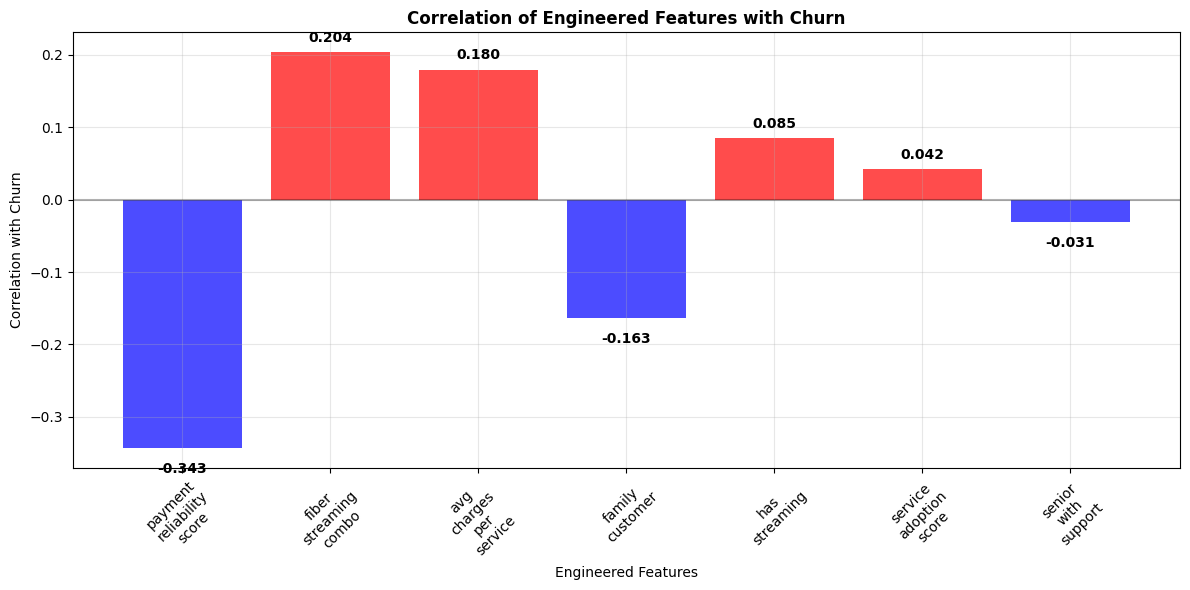

In [13]:
# Analyze correlations between engineered features and churn
engineered_features = ['tenure_category', 'service_adoption_score', 'avg_charges_per_service', 
                      'payment_reliability_score', 'customer_value_segment'] + interaction_features

# Create binary churn for correlation
df_engineered['churn_binary'] = (df_engineered['Churn'] == 'Yes').astype(int)

# Calculate correlations for numerical engineered features
numerical_engineered = ['service_adoption_score', 'avg_charges_per_service', 'payment_reliability_score'] + interaction_features
correlation_with_churn = {}

for feature in numerical_engineered:
    corr = df_engineered[feature].corr(df_engineered['churn_binary'])
    correlation_with_churn[feature] = corr

# Sort by absolute correlation
sorted_correlations = sorted(correlation_with_churn.items(), key=lambda x: abs(x[1]), reverse=True)

print("Correlation of Engineered Features with Churn:")
print("=" * 50)
for feature, corr in sorted_correlations:
    print(f"{feature:25s}: {corr:7.3f}")

# Visualize correlations
features, correlations = zip(*sorted_correlations)
plt.figure(figsize=(12, 6))
colors = ['red' if corr > 0 else 'blue' for corr in correlations]
bars = plt.bar(range(len(features)), correlations, color=colors, alpha=0.7)
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.title('Correlation of Engineered Features with Churn', fontweight='bold')
plt.xlabel('Engineered Features')
plt.ylabel('Correlation with Churn')
plt.xticks(range(len(features)), [f.replace('_', '\n') for f in features], rotation=45)
plt.grid(True, alpha=0.3)

# Add correlation values on bars
for bar, corr in zip(bars, correlations):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + (0.01 if height > 0 else -0.02),
             f'{corr:.3f}', ha='center', va='bottom' if height > 0 else 'top', fontweight='bold')

plt.tight_layout()
plt.show()

### 7. Feature Summary and Selection

In [14]:
# Summary of all features
original_features = list(df.columns)
original_features.remove('Churn')
if 'churn_binary' in original_features:
    original_features.remove('churn_binary')

new_features = ['tenure_category', 'service_adoption_score', 'avg_charges_per_service', 
               'payment_reliability_score', 'customer_value_segment', 'has_streaming', 
               'fiber_streaming_combo', 'senior_with_support', 'family_customer']

print("FEATURE ENGINEERING SUMMARY")
print("=" * 40)
print(f"Original features: {len(original_features)}")
print(f"New engineered features: {len(new_features)}")
print(f"Total features: {len(original_features) + len(new_features)}")

print(f"\nEngineered Features Created:")
for i, feature in enumerate(new_features, 1):
    print(f"{i:2d}. {feature}")

print(f"\nTop 5 Most Correlated Engineered Features with Churn:")
for i, (feature, corr) in enumerate(sorted_correlations[:5], 1):
    print(f"{i}. {feature:25s}: {corr:7.3f}")

# Check final dataset shape and missing values
print(f"\nFinal Dataset:")
print(f"Shape: {df_engineered.shape}")
print(f"Missing values: {df_engineered.isnull().sum().sum()}")
print(f"Memory usage: {df_engineered.memory_usage(deep=True).sum() / 1024 / 1024:.2f} MB")

FEATURE ENGINEERING SUMMARY
Original features: 21
New engineered features: 9
Total features: 30

Engineered Features Created:
 1. tenure_category
 2. service_adoption_score
 3. avg_charges_per_service
 4. payment_reliability_score
 5. customer_value_segment
 6. has_streaming
 7. fiber_streaming_combo
 8. senior_with_support
 9. family_customer

Top 5 Most Correlated Engineered Features with Churn:
1. payment_reliability_score:  -0.343
2. fiber_streaming_combo    :   0.204
3. avg_charges_per_service  :   0.180
4. family_customer          :  -0.163
5. has_streaming            :   0.085

Final Dataset:
Shape: (7043, 32)
Missing values: 11
Memory usage: 9.15 MB


### 8. Save Engineered Features

In [16]:
# Prepare final dataset for modeling
# Remove intermediate columns if needed
columns_to_remove = ['churn_binary']  # Remove binary helper column
df_final = df_engineered.drop(columns=[col for col in columns_to_remove if col in df_engineered.columns])

# Save engineered dataset
output_file = r'D:\MY\Personal Projects\Zuu-Crew Projects\Building Production Ready ML Systems\Advance Telco Customer Churn Prediction\data\processed\telco_features_engineered.csv'
df_final.to_csv(output_file, index=False)

print(f"Feature engineering completed successfully!")
print(f"Engineered dataset saved to: {output_file}")
print(f"Dataset ready for model development...")

# Display final dataset info
print(f"\nFinal Dataset Summary:")
print(f"Rows: {df_final.shape[0]:,}")
print(f"Columns: {df_final.shape[1]}")
print(f"Target variable: Churn ({df_final['Churn'].value_counts()['Yes']:,} churned, {df_final['Churn'].value_counts()['No']:,} retained)")

Feature engineering completed successfully!
Engineered dataset saved to: D:\MY\Personal Projects\Zuu-Crew Projects\Building Production Ready ML Systems\Advance Telco Customer Churn Prediction\data\processed\telco_features_engineered.csv
Dataset ready for model development...

Final Dataset Summary:
Rows: 7,043
Columns: 31
Target variable: Churn (1,869 churned, 5,174 retained)


### 9. Feature Engineering Insights

In [17]:
print("FEATURE ENGINEERING KEY INSIGHTS")
print("=" * 45)

# Tenure category insights
new_customer_churn = df_final[df_final['tenure_category'] == 'New']['Churn'].value_counts(normalize=True)['Yes'] * 100
loyal_customer_churn = df_final[df_final['tenure_category'] == 'Loyal']['Churn'].value_counts(normalize=True)['Yes'] * 100

print(f"\n🏷️  TENURE CATEGORIES:")
print(f"   • New customers (0-12 months): {new_customer_churn:.1f}% churn rate")
print(f"   • Loyal customers (37+ months): {loyal_customer_churn:.1f}% churn rate")
print(f"   • Risk difference: {new_customer_churn - loyal_customer_churn:.1f}x higher for new customers")

# Service adoption insights
low_adoption = df_final[df_final['service_adoption_score'] <= 2]['Churn'].value_counts(normalize=True)['Yes'] * 100
high_adoption = df_final[df_final['service_adoption_score'] >= 6]['Churn'].value_counts(normalize=True)['Yes'] * 100

print(f"\n📊 SERVICE ADOPTION:")
print(f"   • Low adoption (≤2 services): {low_adoption:.1f}% churn rate")
print(f"   • High adoption (≥6 services): {high_adoption:.1f}% churn rate")
print(f"   • Adoption impact: {abs(high_adoption - low_adoption):.1f}% difference")

# Payment reliability insights
low_reliability = df_final[df_final['payment_reliability_score'] <= 3]['Churn'].value_counts(normalize=True)['Yes'] * 100
high_reliability = df_final[df_final['payment_reliability_score'] >= 6]['Churn'].value_counts(normalize=True)['Yes'] * 100

print(f"\n💳 PAYMENT RELIABILITY:")
print(f"   • Low reliability (≤3 score): {low_reliability:.1f}% churn rate")
print(f"   • High reliability (≥6 score): {high_reliability:.1f}% churn rate")
print(f"   • Reliability impact: {low_reliability - high_reliability:.1f}% lower churn for reliable customers")

# Customer value insights
high_value_loyal = df_final[df_final['customer_value_segment'] == 'High_Value_Loyal']['Churn'].value_counts(normalize=True)['Yes'] * 100
high_value_new = df_final[df_final['customer_value_segment'] == 'High_Value_New']['Churn'].value_counts(normalize=True)['Yes'] * 100

print(f"\n💎 CUSTOMER VALUE SEGMENTS:")
print(f"   • High-value loyal customers: {high_value_loyal:.1f}% churn rate")
print(f"   • High-value new customers: {high_value_new:.1f}% churn rate")
print(f"   • Value-tenure interaction: {high_value_new - high_value_loyal:.1f}% higher churn for new high-value")

print(f"\n🔄 INTERACTION EFFECTS:")
fiber_streaming_churn = df_final[df_final['fiber_streaming_combo'] == 1]['Churn'].value_counts(normalize=True)['Yes'] * 100
family_churn = df_final[df_final['family_customer'] == 1]['Churn'].value_counts(normalize=True)['Yes'] * 100
print(f"   • Fiber + Streaming customers: {fiber_streaming_churn:.1f}% churn rate")
print(f"   • Family customers: {family_churn:.1f}% churn rate")

print(f"\n📈 MODELING READINESS:")
print(f"   • {len(new_features)} new features created")
print(f"   • {df_final.shape[1] - 1} total features for modeling")
print(f"   • No missing values remaining")
print(f"   • Ready for ensemble model development")

FEATURE ENGINEERING KEY INSIGHTS

🏷️  TENURE CATEGORIES:
   • New customers (0-12 months): 47.4% churn rate
   • Loyal customers (37+ months): 11.9% churn rate
   • Risk difference: 35.5x higher for new customers

📊 SERVICE ADOPTION:
   • Low adoption (≤2 services): 14.1% churn rate
   • High adoption (≥6 services): 25.0% churn rate
   • Adoption impact: 10.9% difference

💳 PAYMENT RELIABILITY:
   • Low reliability (≤3 score): 46.3% churn rate
   • High reliability (≥6 score): 5.2% churn rate
   • Reliability impact: 41.0% lower churn for reliable customers

💎 CUSTOMER VALUE SEGMENTS:
   • High-value loyal customers: 21.4% churn rate
   • High-value new customers: 63.3% churn rate
   • Value-tenure interaction: 41.8% higher churn for new high-value

🔄 INTERACTION EFFECTS:
   • Fiber + Streaming customers: 39.9% churn rate
   • Family customers: 19.8% churn rate

📈 MODELING READINESS:
   • 9 new features created
   • 30 total features for modeling
   • No missing values remaining
   • R